<a href="https://colab.research.google.com/github/xandeea/Loan-Default-Prediction-Nigeria/blob/main/Loan_Default_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import datetime
#!pip install geocoder
import geocoder
#!pip install catboost
#!pip install --upgrade matplotlib
#!pip install category_encoders
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from category_encoders.target_encoder import TargetEncoder
from category_encoders.cat_boost import CatBoostEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.james_stein import JamesSteinEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder
from lightgbm import LGBMClassifier
import lightgbm as lgb
from xgboost import XGBClassifier, plot_importance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
df_train_demo = pd.read_csv('https://raw.githubusercontent.com/xandeea/Loan-Default-Prediction-Nigeria/main/dados/traindemographics.csv')
df_train_perf = pd.read_csv('https://raw.githubusercontent.com/xandeea/Loan-Default-Prediction-Nigeria/main/dados/trainperf.csv')
df_train_prevloans = pd.read_csv('https://raw.githubusercontent.com/xandeea/Loan-Default-Prediction-Nigeria/main/dados/trainprevloans.csv')

# **Tratamento de dados**

## **DataSet de Informações Demográficas**

In [3]:
df_train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10 00:00:00.000000,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21 00:00:00.000000,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01 00:00:00.000000,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19 00:00:00.000000,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22 00:00:00.000000,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN


In [4]:
# convertendo a coluna com data para datetime
df_train_demo["birthdate"] = pd.to_datetime(df_train_demo["birthdate"])

# criando uma nova coluna com o dia de hoje
df_train_demo['today'] = pd.to_datetime("today")

# calculando a idade da pessoa fazendo a diferença das duas colunas acima
df_train_demo['age'] = round((df_train_demo['today'] - df_train_demo['birthdate']).dt.days / 365)

In [5]:
# criando uma função de geocodificação reversa, convertendo latitude e longitude em vila, estado e condado
def geo_rev(x):
    g = geocoder.osm([x.latitude_gps, x.longitude_gps], method='reverse').json
    if g:
        return g.get('village'), g.get('state'), g.get('county')
    else:
        return 'no info'

In [6]:
# aplicando a função para cada linha do dataset e criando uma nova coluna endereço
df_train_demo['address'] = df_train_demo[['latitude_gps', 'longitude_gps']].apply(geo_rev, axis=1)

In [7]:
# separando a coluna endereço em 3 colunas diferentes
df_train_demo[['village','state','county']] = df_train_demo['address'].tolist()

In [8]:
# visualizando o novo dataset
df_train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,today,age,address,village,state,county
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.319219,6.528604,GT Bank,NaN,NaN,NaN,2022-07-01 14:52:52.391322,49.0,"(Isolo, Lagos, Oshodi/Isolo)",Isolo,Lagos,Oshodi/Isolo
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.325598,7.119403,Sterling Bank,NaN,Permanent,NaN,2022-07-01 14:52:52.391322,36.0,"(Ijapo, Ogun, Abeokuta South)",Ijapo,Ogun,Abeokuta South
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.746100,5.563174,Fidelity Bank,NaN,NaN,NaN,2022-07-01 14:52:52.391322,35.0,"(None, Delta, Uvwie)",None,Delta,Uvwie
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.362850,6.642485,GT Bank,NaN,Permanent,NaN,2022-07-01 14:52:52.391322,31.0,"(None, Lagos, Ikeja)",None,Lagos,Ikeja
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.455332,11.971410,GT Bank,NaN,Permanent,NaN,2022-07-01 14:52:52.391322,40.0,"(None, Kano, Gwale)",None,Kano,Gwale


In [9]:
# removendo as colunas que já foram usadas e transformadas em outras
df_train_demo = df_train_demo.drop(['birthdate','today', 'longitude_gps', 'latitude_gps', 'address'], axis=1)

In [10]:
# verificando se existem índices duplicados
duplicate_rows = df_train_demo[df_train_demo['customerid'].duplicated()]
duplicate_rows.head()

,customerid,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age,village,state,county
159,8a858fca5c35df2c015c39ad8695343e,Savings,GT Bank,NaN,Permanent,NaN,42.0,Bode Olude,Ogun,Abeokuta North
517,8a858edd57f790040157ffe9b6ed3fbb,Other,First Bank,NaN,Permanent,Secondary,34.0,Lemomu,Ogun,Obafemi Owode
776,8a858f965bb63a25015bbf63fd062e2e,Savings,Stanbic IBTC,NaN,Permanent,NaN,48.0,None,Ogun,None
1015,8a858fe65675195a015679452588279c,Savings,UBA,NaN,Permanent,NaN,40.0,Aso,Federal Capital Territory,Municipal Area Council
1090,8a858e6c5c88d145015c8b9627cd5a48,Savings,Sterling Bank,NaN,Permanent,NaN,43.0,Iponri,Lagos,Surulere


In [11]:
# removendo linhas com o mesmo id
df_train_demo = df_train_demo.drop_duplicates(subset=['customerid'])

In [12]:
# visualizando se as linhas foram removidas
duplicate_rows = df_train_demo[df_train_demo['customerid'].duplicated()]
duplicate_rows.head()

,customerid,bank_account_type,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients,age,village,state,county


In [13]:
df_train_demo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4334 entries, 0 to 4345
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerid                  4334 non-null   object 
 1   bank_account_type           4334 non-null   object 
 2   bank_name_clients           4334 non-null   object 
 3   bank_branch_clients         51 non-null     object 
 4   employment_status_clients   3686 non-null   object 
 5   level_of_education_clients  586 non-null    object 
 6   age                         4334 non-null   float64
 7   village                     2458 non-null   object 
 8   state                       4334 non-null   object 
 9   county                      3893 non-null   object 
dtypes: float64(1), object(9)
memory usage: 372.5+ KB


## **DataSet de Empréstimos Anteriores**

In [14]:
df_train_prevloans.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40.000000,2016-08-15 17:22:32.000000,10000.0,13000.0,30,2016-09-01 16:06:48.000000,NaN,2016-09-14 00:00:00.000000,2016-09-01 15:51:43.000000
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07.000000,2017-04-28 17:38:53.000000,10000.0,13000.0,30,2017-05-28 14:44:49.000000,NaN,2017-05-30 00:00:00.000000,2017-05-26 00:00:00.000000
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25.000000,2017-03-05 09:56:19.000000,20000.0,23800.0,30,2017-04-26 22:18:56.000000,NaN,2017-04-04 00:00:00.000000,2017-04-26 22:03:47.000000
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55.000000,2017-04-09 17:25:42.000000,10000.0,11500.0,15,2017-04-24 01:35:52.000000,NaN,2017-04-24 00:00:00.000000,2017-04-24 00:48:43.000000
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57.000000,2017-06-17 08:29:50.000000,10000.0,11500.0,15,2017-07-14 21:18:43.000000,NaN,2017-07-03 00:00:00.000000,2017-07-14 21:08:35.000000


In [15]:
# convertendo as colunas que contém data para datetime
df_train_prevloans["firstrepaiddate"] = pd.to_datetime(df_train_prevloans["firstrepaiddate"]).dt.normalize()
df_train_prevloans["firstduedate"] = pd.to_datetime(df_train_prevloans["firstduedate"]).dt.normalize()
df_train_prevloans["closeddate"] = pd.to_datetime(df_train_prevloans["closeddate"]).dt.normalize()
df_train_prevloans["creationdate"] = pd.to_datetime(df_train_prevloans["creationdate"]).dt.normalize()

In [16]:
# criando uma nova coluna em dias (quando o cliente pagou o empréstimo - quando o cliente deveria pagar o empréstimo)
df_train_prevloans['days_to_1_payment'] = df_train_prevloans['firstrepaiddate'] - df_train_prevloans['firstduedate']

# criando uma nova coluna em dias (quando o cliente pediu o empréstimo - quando o cliente quitou o empréstimo)
df_train_prevloans['days_to_close'] = df_train_prevloans['closeddate'] - df_train_prevloans['creationdate']

In [17]:
# removendo as colunas que já foram usadas e transformadas em outras
df_train_prevloans = df_train_prevloans.drop(['approveddate','creationdate','closeddate','firstduedate', 'firstrepaiddate'], axis=1)

In [18]:
# agrupando as colunas numéricas por id, pegando valor mínimo, máximo e médio e colocando essas informações em um novo dataset
df_train_prevloans_agg = df_train_prevloans.groupby('customerid')[['loannumber','loanamount','totaldue','termdays', 'days_to_1_payment', 'days_to_close']].agg(['min','mean','max','sum'])
df_train_prevloans_agg.columns = ['_'.join(col) if type(col) is tuple else col for col in df_train_prevloans_agg.columns.values]

In [19]:
# visualizando o novo dataset criado
df_train_prevloans_agg.head()

,loannumber_min,loannumber_mean,loannumber_max,loannumber_sum,loanamount_min,loanamount_mean,loanamount_max,loanamount_sum,totaldue_min,totaldue_mean,...,termdays_max,termdays_sum,days_to_1_payment_min,days_to_1_payment_mean,days_to_1_payment_max,days_to_1_payment_sum,days_to_close_min,days_to_close_mean,days_to_close_max,days_to_close_sum
customerid,,,,,,,,,,,,,,,,,,,,,
8a1088a0484472eb01484669e3ce4e0b,1,1.0,1,1,10000.0,10000.000000,10000.0,10000.0,11500.0,11500.000000,...,15,15,6 days,6 days 00:00:00,6 days,6 days,22 days,22 days 00:00:00,22 days,22 days
8a1a1e7e4f707f8b014f797718316cad,1,2.5,4,10,10000.0,17500.000000,30000.0,70000.0,13000.0,22375.000000,...,60,150,-1 days,-1 days +18:00:00,1 days,-1 days,29 days,31 days 18:00:00,35 days,127 days
8a1a32fc49b632520149c3b8fdf85139,1,4.0,7,28,10000.0,12857.142857,20000.0,90000.0,11500.0,15214.285714,...,30,135,-2 days,-1 days +13:42:51.428571429,1 days,-3 days,14 days,19 days 00:00:00,30 days,133 days
8a1eb5ba49a682300149c3c068b806c7,1,4.5,8,36,10000.0,16250.000000,30000.0,130000.0,13000.0,20300.000000,...,60,270,-13 days,-4 days +21:00:00,8 days,-25 days,18 days,28 days 15:00:00,50 days,229 days
8a1edbf14734127f0147356fdb1b1eb2,1,1.5,2,3,10000.0,10000.000000,10000.0,20000.0,11500.0,12250.000000,...,30,45,-8 days,-4 days +00:00:00,0 days,-8 days,15 days,18 days 12:00:00,22 days,37 days


In [20]:
# verificando se existem índices duplicados
duplicate_rows = df_train_prevloans_agg[df_train_prevloans_agg.index.duplicated()]
duplicate_rows

,loannumber_min,loannumber_mean,loannumber_max,loannumber_sum,loanamount_min,loanamount_mean,loanamount_max,loanamount_sum,totaldue_min,totaldue_mean,...,termdays_max,termdays_sum,days_to_1_payment_min,days_to_1_payment_mean,days_to_1_payment_max,days_to_1_payment_sum,days_to_close_min,days_to_close_mean,days_to_close_max,days_to_close_sum
customerid,,,,,,,,,,,,,,,,,,,,,


# **Agrupando os DataSets para criação do modelo**

In [55]:
# agrupando os três datasets
df = df_train_perf.merge(df_train_demo, how ='left',on='customerid').merge(df_train_prevloans_agg, how='left', on='customerid')

In [56]:
# convertendo os valores Bad em 0 e Good em 1
df['good_bad_flag'] = np.where(df['good_bad_flag']== 'Bad', 0, 1)
df.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,...,termdays_max,termdays_sum,days_to_1_payment_min,days_to_1_payment_mean,days_to_1_payment_max,days_to_1_payment_sum,days_to_close_min,days_to_close_mean,days_to_close_max,days_to_close_sum
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56.000000,2017-07-25 07:22:47.000000,30000.0,34500.0,30,NaN,1,...,30.0,330.0,-29 days,-1 days +02:10:54.545454546,39 days,-10 days,1 days,30 days 00:00:00,69 days,330 days
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41.000000,2017-07-05 16:04:18.000000,15000.0,17250.0,30,NaN,1,...,NaN,NaN,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57.000000,2017-07-06 13:52:51.000000,20000.0,22250.0,15,NaN,1,...,30.0,105.0,-10 days,0 days 20:00:00,30 days,5 days,6 days,18 days 20:00:00,45 days,113 days
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41.000000,2017-07-27 18:00:35.000000,10000.0,11500.0,15,NaN,1,...,30.0,45.0,4 days,7 days 12:00:00,11 days,15 days,27 days,31 days 12:00:00,36 days,63 days
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45.000000,2017-07-03 22:42:39.000000,40000.0,44000.0,30,NaN,1,...,60.0,300.0,-8 days,-4 days +21:00:00,-1 days,-25 days,23 days,27 days 09:00:00,30 days,219 days


In [57]:
# convertendo as colunas data para números
df['days_to_1_payment_min'] = df['days_to_1_payment_min'].dt.days
df['days_to_1_payment_mean'] = df['days_to_1_payment_mean'].dt.days
df['days_to_1_payment_max'] = df['days_to_1_payment_max'].dt.days
df['days_to_1_payment_sum'] = df['days_to_1_payment_sum'].dt.days
df['days_to_close_min'] = df['days_to_close_min'].dt.days
df['days_to_close_mean'] = df['days_to_close_mean'].dt.days
df['days_to_close_max'] = df['days_to_close_max'].dt.days
df['days_to_close_sum'] = df['days_to_close_sum'].dt.days

In [58]:
# removendo as colunas que não serão usadas no modelo
df = df.drop(['customerid','systemloanid','approveddate','creationdate', 'referredby'], axis=1)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4368 entries, 0 to 4367
Data columns (total 38 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   loannumber                  4368 non-null   int64  
 1   loanamount                  4368 non-null   float64
 2   totaldue                    4368 non-null   float64
 3   termdays                    4368 non-null   int64  
 4   good_bad_flag               4368 non-null   int64  
 5   bank_account_type           3269 non-null   object 
 6   bank_name_clients           3269 non-null   object 
 7   bank_branch_clients         33 non-null     object 
 8   employment_status_clients   2776 non-null   object 
 9   level_of_education_clients  443 non-null    object 
 10  age                         3269 non-null   float64
 11  village                     1850 non-null   object 
 12  state                       3269 non-null   object 
 13  county                      2943 

# **EDA**

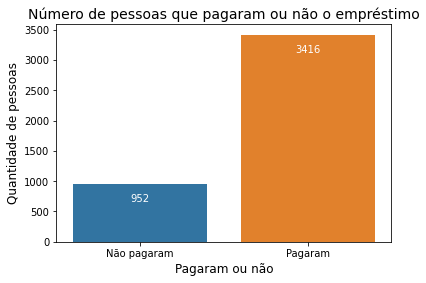

In [60]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data = df, x = 'good_bad_flag')
ax.set_title('Número de pessoas que pagaram ou não o empréstimo', fontsize=14)
ax.set_xlabel('Pagaram ou não', fontsize=12)
ax.set_ylabel('Quantidade de pessoas', fontsize=12)
ax.set_xticklabels(["Não pagaram", "Pagaram"], fontsize=10)
ax.bar_label(ax.containers[0], padding=-20, color='white')
plt.show()

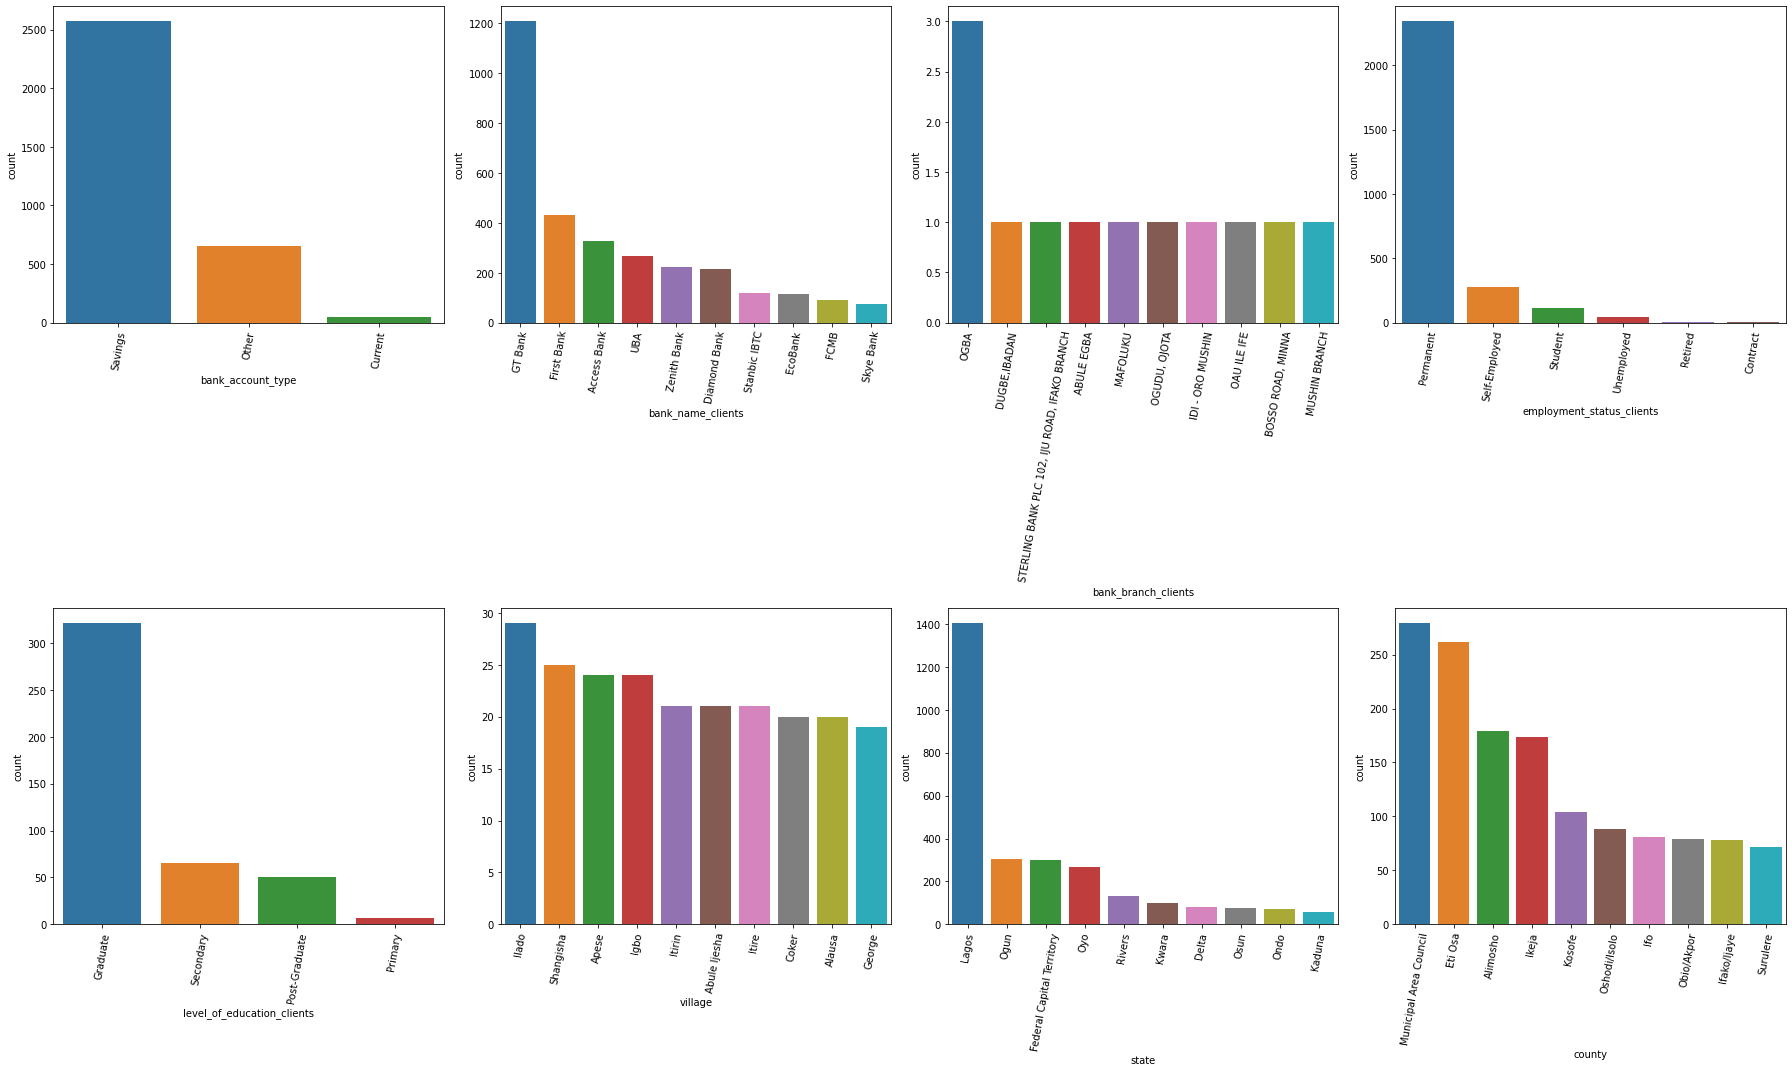

In [61]:
categorical = ['bank_account_type', 'bank_name_clients',
       'bank_branch_clients', 'employment_status_clients',
       'level_of_education_clients', 'village', 'state', 'county']
fig, ax = plt.subplots(2, 4, figsize=(25, 15))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(x = df[variable], ax=subplot,  order = df[variable].value_counts()[:10].index)
    for label in subplot.get_xticklabels():
        label.set_rotation(80)
plt.tight_layout()

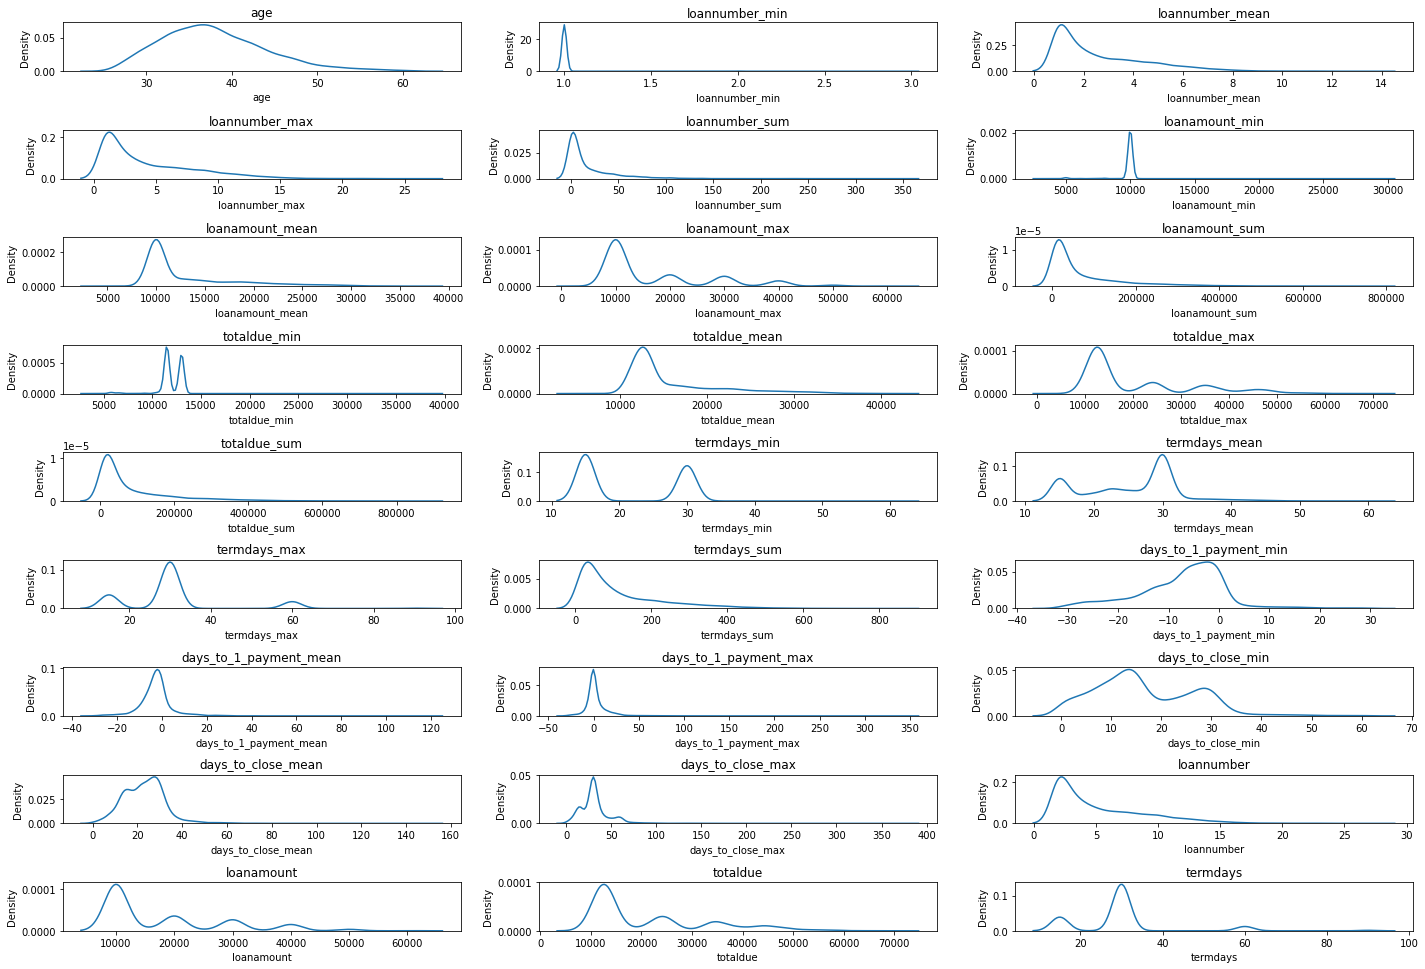

In [62]:
numeric = ['age', 'loannumber_min', 'loannumber_mean', 'loannumber_max',
       'loannumber_sum', 'loanamount_min', 'loanamount_mean', 'loanamount_max',
       'loanamount_sum', 'totaldue_min', 'totaldue_mean', 'totaldue_max',
       'totaldue_sum', 'termdays_min', 'termdays_mean', 'termdays_max',
       'termdays_sum', 'days_to_1_payment_min', 'days_to_1_payment_mean',
       'days_to_1_payment_max', 'days_to_close_min', 'days_to_close_mean',
       'days_to_close_max', 'loannumber', 'loanamount', 'totaldue',
       'termdays']
a = len(numeric)
b = 3
c = 1

fig = plt.figure(figsize=(20,40))

for i in numeric:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.kdeplot(data = df, x = i)
    c = c + 1
plt.tight_layout()

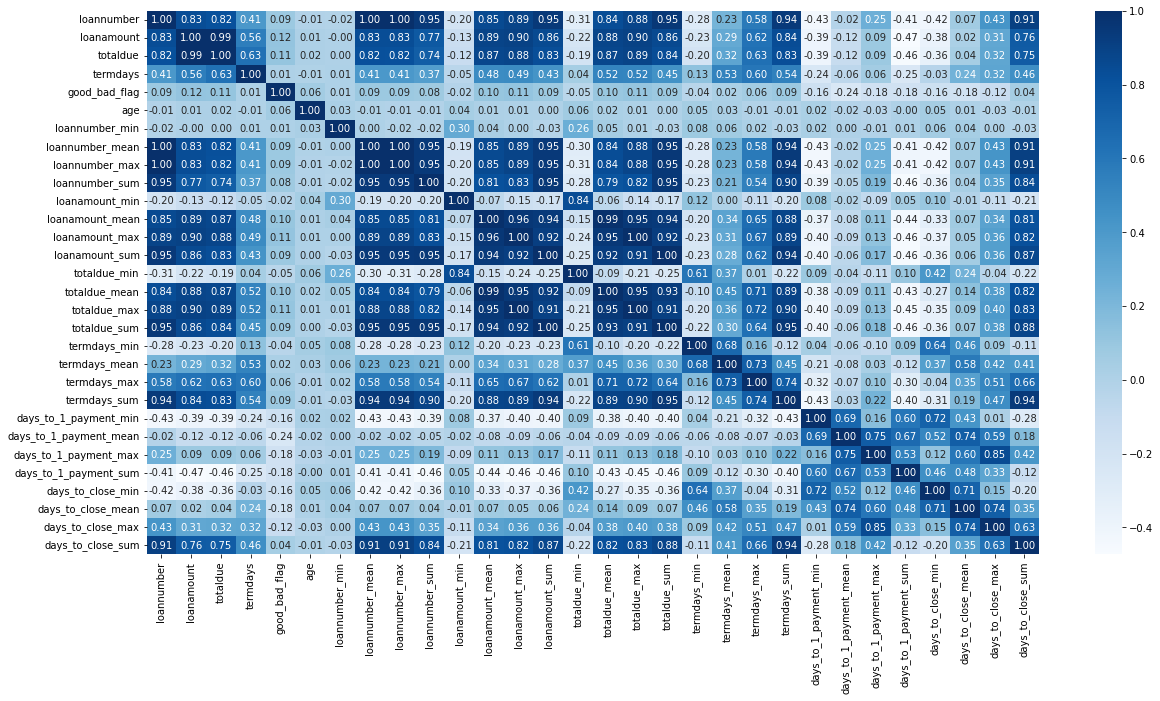

In [63]:
fig = plt.figure(figsize=(20,10))
sns.heatmap(df.corr(),
            annot = True,
            fmt = '.2f',
            cmap='Blues')
plt.show()

## **Pipeline**

In [64]:
# separando as variáveis preditoras e variável alvo
x = df.drop(['good_bad_flag'], axis=1)
y = df['good_bad_flag']

# separando a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=7)

In [65]:
# dividindo as colunas em numéricas e categóricas para o pipeline
numeric_features = x.select_dtypes(['float64', 'int64']).columns
categorical_features = x.select_dtypes(['object']).columns

In [ ]:
# criando o pipeline
strategy_numeric_list = [ 
    'median', 
    'mean'
]

strategy_category_list = [ 
    'most_frequent', 
    'constant'
]

scalers_list = [
    StandardScaler(),
    MinMaxScaler(),
    RobustScaler()
]

encoders_list = [
    CatBoostEncoder(),
    TargetEncoder(),
    WOEEncoder(),
    JamesSteinEncoder(),
    LeaveOneOutEncoder()
]

classifiers_list = [
    KNeighborsClassifier(3),
    SVC(),
    LogisticRegression(max_iter = 3000),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    CatBoostClassifier(iterations=2, learning_rate=1, depth=2),
    LGBMClassifier(),
    XGBClassifier()
]

appended_data = []

for n_strategy in strategy_numeric_list:
  for c_strategy in strategy_category_list:
    for scaler in scalers_list:
      for encoder in encoders_list:
        for classifier in classifiers_list:
          numeric_transformer = Pipeline(
              steps=[('imputer', SimpleImputer(strategy=n_strategy)), ('scaler', scaler)]
          )

          categorical_transformer = Pipeline(
              steps=[("imputer", SimpleImputer(strategy=c_strategy)), ('encoder', encoder)]
          )

          preprocessor = ColumnTransformer(
              transformers=[
                  ("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)
              ]
          )
          pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", classifier)])  
          pipe.fit(X_train, y_train)
          y_pred = pipe.predict(X_test)
          score = f1_score(y_test, y_pred)
          list = [n_strategy,c_strategy,scaler,encoder,classifier,score]
          appended_data.append(list)

In [67]:
# visualizando os melhores resultados do pipeline
columns = ['numeric_imputer','category_imputer','scaler','encoder','classifier','score']

df_results = pd.DataFrame(appended_data, columns = columns)
df_results.head(5).sort_values(by=['score'], ascending=False)

,numeric_imputer,category_imputer,scaler,encoder,classifier,score
2,median,most_frequent,StandardScaler(),CatBoostEncoder(),LogisticRegression(max_iter=3000),0.881579
1,median,most_frequent,StandardScaler(),CatBoostEncoder(),SVC(),0.879686
4,median,most_frequent,StandardScaler(),CatBoostEncoder(),"(DecisionTreeClassifier(max_features='auto', r...",0.877241
0,median,most_frequent,StandardScaler(),CatBoostEncoder(),KNeighborsClassifier(n_neighbors=3),0.857143
3,median,most_frequent,StandardScaler(),CatBoostEncoder(),DecisionTreeClassifier(),0.781726


In [73]:
numeric_transformer = Pipeline(
  steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler()	)]
)

categorical_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy='most_frequent'	)), ('encoder', CatBoostEncoder())]
)

preprocessor = ColumnTransformer(
  transformers=[
  ("num", numeric_transformer, numeric_features),
  ("cat", categorical_transformer, categorical_features)
  ]
)

k_vs_score = []
for k in range(1,38,2):
  selector = SelectKBest(score_func=f_classif, k = k)
  clf =  LogisticRegression(max_iter=3000)
  pipe = Pipeline(steps=[("preprocessor", preprocessor), ('selector', selector), ('clf', clf)])  

  pipe.fit(X_train, y_train)
  y_pred = pipe.predict(X_test)
  score = f1_score(y_test, y_pred)
  print('k =  {} - Score = {}'.format(k,score))
  k_vs_score.append(score)

k =  1 - Score = 0.8794079233783195
k =  3 - Score = 0.8788142981691368
k =  5 - Score = 0.8788142981691368
k =  7 - Score = 0.8806296458242239
k =  9 - Score = 0.8809106830122592
k =  11 - Score = 0.8817863397548161
k =  13 - Score = 0.8817863397548161
k =  15 - Score = 0.8814004376367615
k =  17 - Score = 0.8809106830122592
k =  19 - Score = 0.8816827344434706
k =  21 - Score = 0.8816827344434706
k =  23 - Score = 0.8821725799386771
k =  25 - Score = 0.8835376532399299
k =  27 - Score = 0.8825591586327782
k =  29 - Score = 0.8825591586327782
k =  31 - Score = 0.8825591586327782
k =  33 - Score = 0.8811924594476107
k =  35 - Score = 0.8811924594476107
k =  37 - Score = 0.881578947368421


In [89]:
numeric_transformer = Pipeline(
  steps=[('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler()	)]
)

categorical_transformer = Pipeline(
  steps=[("imputer", SimpleImputer(strategy='most_frequent'	)), ('encoder', CatBoostEncoder())]
)

preprocessor = ColumnTransformer(
  transformers=[
  ("num", numeric_transformer, numeric_features),
  ("cat", categorical_transformer, categorical_features)
  ]
)


selector = SelectKBest(score_func=f_classif, k = 25)
clf =  LogisticRegression(class_weight={0:3.5, 1:1}, max_iter=3000)
pipe = Pipeline(steps=[("preprocessor", preprocessor), ('selector', selector), ('clf', clf)])  

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
class_rep = classification_report(y_test, y_pred)
print(class_rep)


pd.Series(selector.scores_, index=X_train.columns).sort_values(ascending=False).head(15)

              precision    recall  f1-score   support

           0       0.34      0.66      0.45       277
           1       0.88      0.66      0.75      1034

    accuracy                           0.66      1311
   macro avg       0.61      0.66      0.60      1311
weighted avg       0.76      0.66      0.69      1311



totaldue_mean          190.862207
termdays_mean          108.694592
totaldue_max           103.957994
totaldue_sum            88.851732
termdays_min            79.405662
totaldue_min            76.656346
termdays_max            44.429943
loanamount              35.663627
state                   35.262053
loannumber_max          34.917572
totaldue                30.893278
village                 30.289663
loannumber_mean         28.568454
bank_branch_clients     20.910895
loannumber              20.909475
dtype: float64

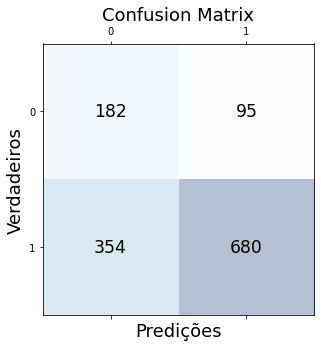

In [90]:
conf_matrix = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
plt.xlabel('Predições', fontsize=18)
plt.ylabel('Verdadeiros', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()